In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"faeghekashani","key":"983d42709f0224e3e2018a180c821997"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d rajkumarl/people-clothing-segmentation

100% 614M/616M [00:28<00:00, 24.0MB/s]
100% 616M/616M [00:28<00:00, 22.4MB/s]


In [ ]:
!unzip people-clothing-segmentation.zip -d data

In [4]:
!pip install -q git+https://github.com/tensorflow/examples.git

  Preparing metadata (setup.py) ... done


In [5]:
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
from pathlib import Path
import re
from skimage import measure
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
import matplotlib as mpl
import tqdm
import tensorflow as tf
import keras
from tensorflow_examples.models.pix2pix import pix2pix
from sklearn.model_selection import train_test_split
from keras.utils import normalize
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.callbacks import LearningRateScheduler
from keras.metrics import MeanIoU
from keras.applications import MobileNetV2
from keras.losses import SparseCategoricalCrossentropy
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

# Load Data

In [6]:
images_path = "./data/png_images/IMAGES"
masks_path = "./data/png_masks/MASKS"

In [7]:
OUTPUT_CHANNELS = 9
classes = {'bg':0, 'accessories': 1,  'bag': 2,  'clothes': 3, 'shoes': 4, 'glasses': 5,  'hair': 6,  'hat': 7,  'skin': 8}
convs = {0: 0, 1: 1, 2: 2, 3: 3, 4: 3, 5: 3, 6: 3, 7: 4, 8: 3, 9: 1, 10: 3, 11: 3, 12: 4, 13: 3, 14: 3, 15: 1, 16: 4, 17: 5, 18: 3, 19: 6, 20: 7, 21: 4, 22: 3, 23: 3, 24: 3, 25: 3, 26: 3, 27: 3, 28: 4, 29: 1, 30: 3, 31: 3, 32: 4, 33: 3, 34: 1, 35: 3, 36: 4, 37: 3, 38: 3, 39: 4, 40: 3, 41: 8, 42: 3, 43: 4, 44: 3, 45: 3, 46: 3, 47: 5, 48: 3, 49: 3, 50: 3, 51: 3, 52: 3, 53: 3, 54: 3, 55: 3, 56: 3, 57: 1, 58: 4}

In [8]:
#Capture training image info as a list
images_paths = []
masks_paths = []

for imgname in os.listdir(images_path):
  images_paths.append(os.path.join(images_path,imgname))

for imgname in os.listdir(masks_path):
  masks_paths.append(os.path.join(masks_path,imgname))

In [ ]:
print(images_paths[:5])

['./data/png_images/IMAGES/img_0085.png', './data/png_images/IMAGES/img_0051.png', './data/png_images/IMAGES/img_0276.png', './data/png_images/IMAGES/img_0139.png', './data/png_images/IMAGES/img_0443.png']


In [ ]:
print(masks_paths[:5])

['./data/png_masks/MASKS/seg_0392.png', './data/png_masks/MASKS/seg_0520.png', './data/png_masks/MASKS/seg_0476.png', './data/png_masks/MASKS/seg_0882.png', './data/png_masks/MASKS/seg_0860.png']


In [9]:
images_paths.sort()
masks_paths.sort()

In [10]:
def standardize(x):
    x = np.array(x, dtype='float64')
    x -= np.min(x)
    x /= np.percentile(x, 98)
    x[x > 1] = 1
    return x
def preprocessing(img):
    image = np.array(img)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image = np.zeros_like(image)
    image[:,:,0] = gray
    image[:,:,1] = gray
    image[:,:,2] = gray
    image = standardize(image)
    return image

In [11]:
#Resizing images, if needed
SIZE_X = 256
SIZE_Y = 256
n_classes=9 #Number of classes for segmentation

#Capture training image info as a list
train_images = []
train_masks = []

for imgpath in tqdm.tqdm(images_paths):
  img = cv2.imread(imgpath)
  img = cv2.resize(img, (SIZE_Y, SIZE_X))
  img = preprocessing(img)
  train_images.append(img)


for maskpath in tqdm.tqdm(masks_paths):
  mask0 = cv2.imread(maskpath, 0)
  mask1 = cv2.resize(mask0, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
  for oldnum in range(0,59):  #change number of classes from 59 to 9 classes
      new_num = convs[oldnum]
      mask1[mask1==oldnum]=new_num
  train_masks.append(mask1)

train_images = np.array(train_images)
train_masks = np.array(train_masks)

X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size = 0.10, shuffle=True, random_state = 1)
print("Class values: ", np.unique(y_train))


100%|██████████| 1000/1000 [00:02<00:00, 453.24it/s]


Class values:  [0 1 2 3 4 5 6 7 8]


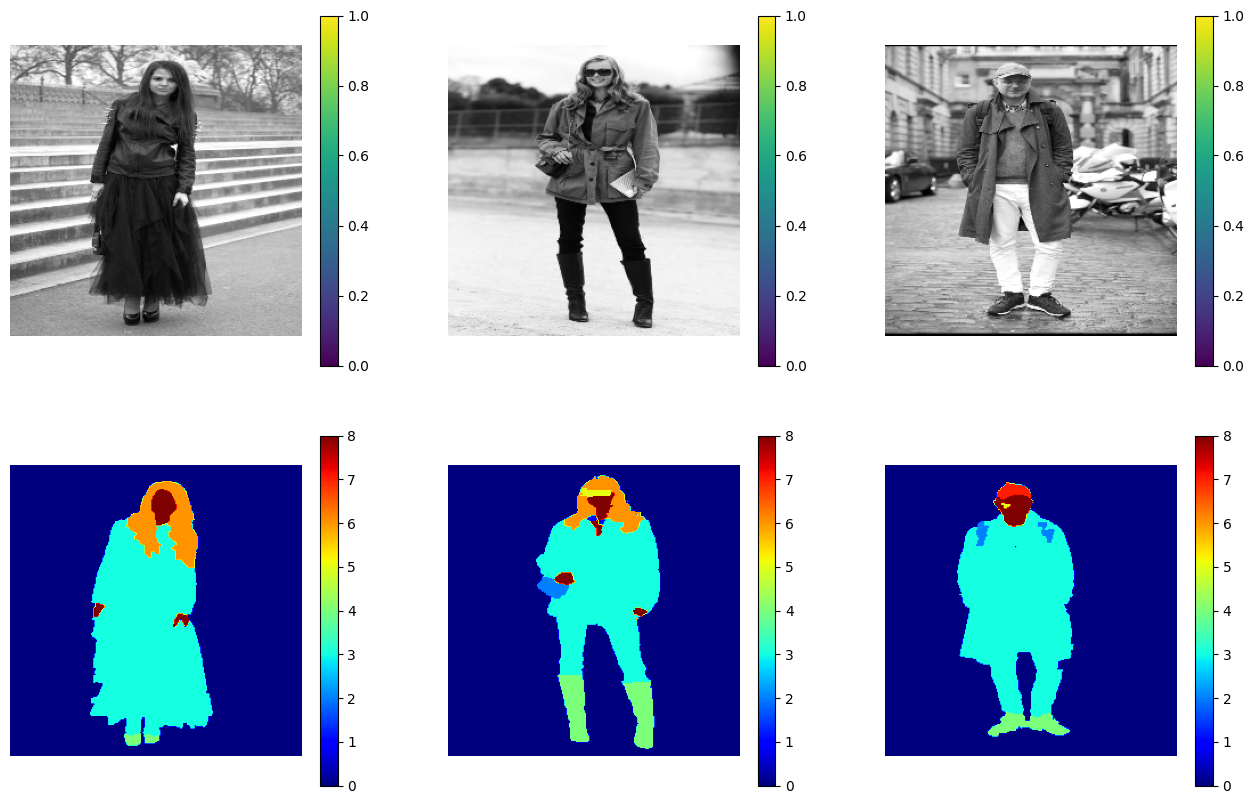

In [ ]:
NORM = mpl.colors.Normalize(vmin=0, vmax=8)

plt.figure(figsize=(16,10))
for i in range(1,4):
    plt.subplot(2,3,i)
    img = train_images[i]
    plt.imshow(img)
    plt.colorbar()
    plt.axis('off')

for i in range(4,7):
    plt.subplot(2,3,i)
    img = np.squeeze(train_masks[i-3])
    plt.imshow(img, cmap='jet', norm=NORM)
    plt.colorbar()
    plt.axis('off')
plt.show()

# Define Model

In [12]:
def unet_model(output_channels):
    IMG_HEIGHT = X_train.shape[1]
    IMG_WIDTH  = X_train.shape[2]
    IMG_CHANNELS = X_train.shape[3]

    base_model = MobileNetV2(input_shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS], include_top=False)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]

    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = Model(inputs=base_model.input, outputs=base_model_outputs)

    down_stack.trainable = False

    up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

    inputs = Input(shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = Conv2DTranspose(OUTPUT_CHANNELS, 3, strides=2, padding='same')  #64x64 -> 128x128

    x = last(x)

    return Model(inputs=inputs, outputs=x)

In [13]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(epoch, dataset=None, num=50):
  if dataset:

    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        plt.figure(figsize=(15, 10))
        plt.subplot(231)
        plt.title('Testing Image')
        plt.imshow(image[0], cmap='gray')
        plt.subplot(232)
        plt.title('Ground Truth')
        plt.imshow(mask[0], cmap='jet')
        plt.subplot(233)
        plt.title('Prediction on test image')
        plt.imshow(create_mask(pred_mask), cmap='jet')

        plt.savefig(f"results/mask_{str(i)}.png")

        plt.show()
  else:
      fig = plt.figure(figsize=(12, 12))
      fig.suptitle(f"\n Epoch: {str(epoch)}\n", fontsize=16)

      plt.subplot(331)
      plt.title('Testing Image')
      plt.imshow(train_images[num], cmap='gray')
      plt.subplot(332)
      plt.title('Ground Truth')
      plt.imshow(train_masks[num], cmap='jet')
      plt.subplot(333)
      plt.title('Prediction on test image')
      plt.imshow(create_mask(model.predict(train_images[num][tf.newaxis, ...]))[:,:,0], cmap='jet')

      plt.subplot(334)
      plt.imshow(train_images[num+16], cmap='gray')
      plt.subplot(335)
      plt.imshow(train_masks[num+16], cmap='jet')
      plt.subplot(336)
      plt.imshow(create_mask(model.predict(train_images[num+16][tf.newaxis, ...]))[:,:,0], cmap='jet')
      plt.subplot(337)
      plt.imshow(train_images[num+14], cmap='gray')
      plt.subplot(338)
      plt.imshow(train_masks[num+14], cmap='jet')
      plt.subplot(339)
      plt.imshow(create_mask(model.predict(train_images[num+14][tf.newaxis, ...]))[:,:,0], cmap='jet')

      #plt.savefig(f"results/mask_{str(num+100)}_{str(epoch)}.png")

      plt.show()

In [14]:
#IoU = keras.metrics.MeanIoU(num_classes=9)

model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

9406464/9406464 [==============================] - 1s 0us/step


In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 128, 128, 96),       1841984   ['input_2[0][0]']             
                              (None, 64, 64, 144),                                                
                              (None, 32, 32, 192),                                                
                              (None, 16, 16, 576),                                                
                              (None, 8, 8, 320)]                                                  
                                                                                            

# Train

Epoch 1/20
1/1 [==============================] - 0s 23ms/step


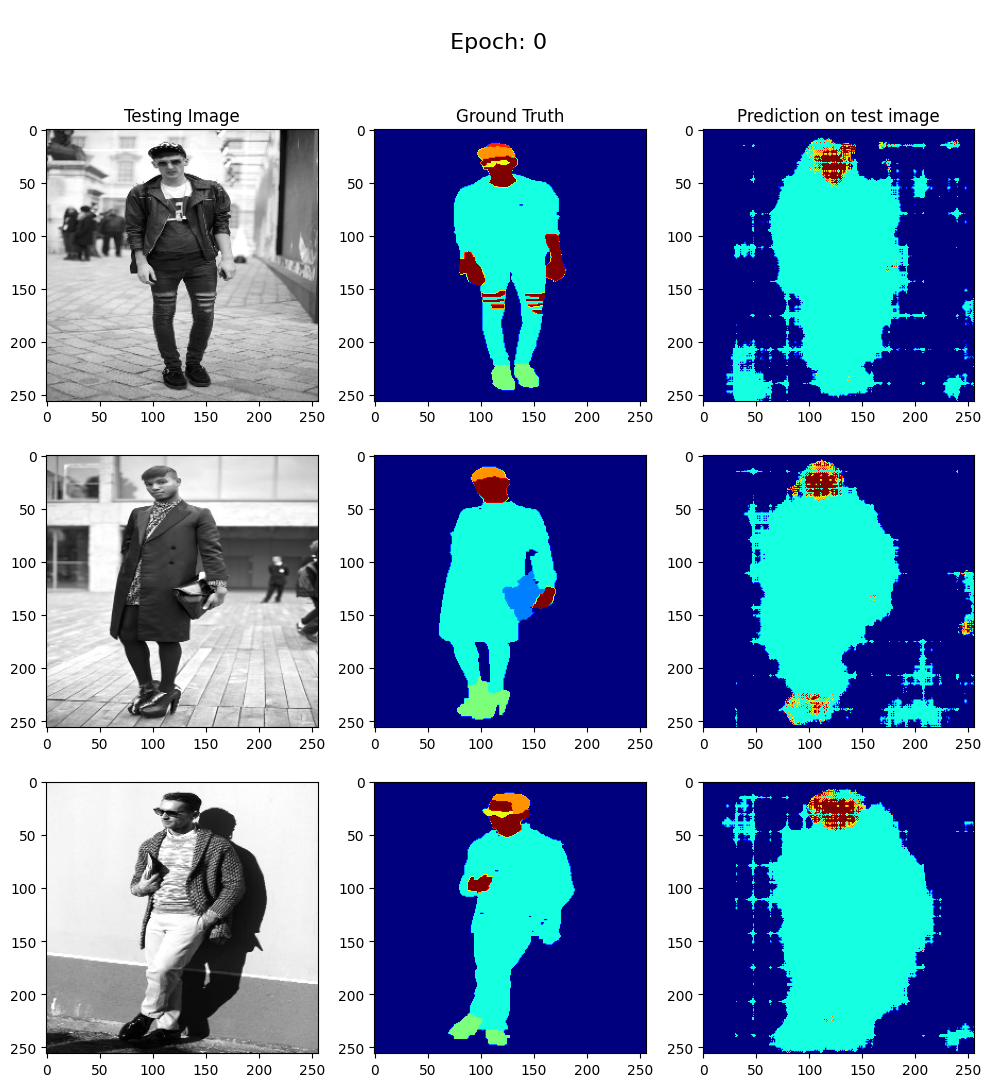


Sample Prediction after epoch 1

56/56 [==============================] - 25s 209ms/step - loss: 0.5614 - accuracy: 0.8484 - val_loss: 1.2442 - val_accuracy: 0.7808
Epoch 2/20
1/1 [==============================] - 0s 23ms/step


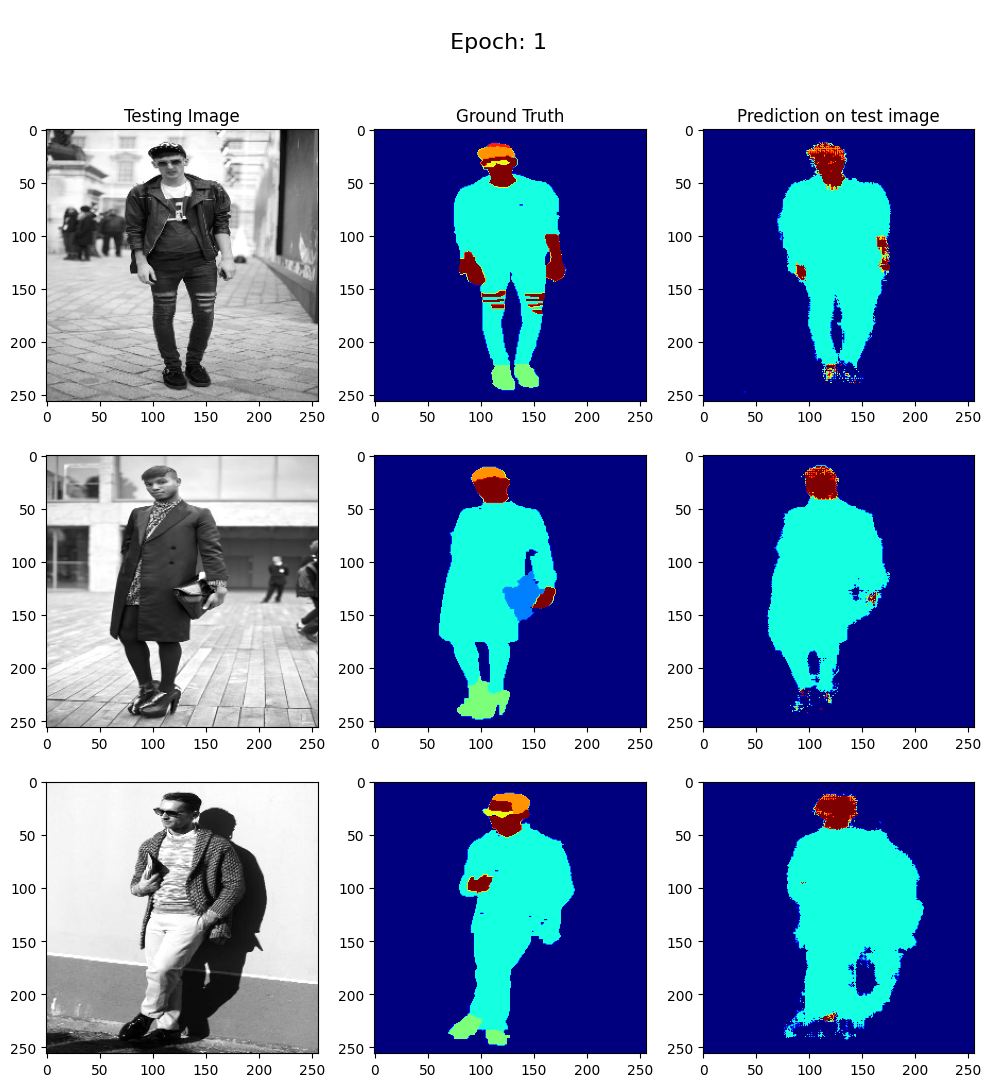


Sample Prediction after epoch 2

56/56 [==============================] - 11s 150ms/step - loss: 0.2399 - accuracy: 0.9295 - val_loss: 0.2442 - val_accuracy: 0.9248
Epoch 3/20
1/1 [==============================] - 0s 26ms/step


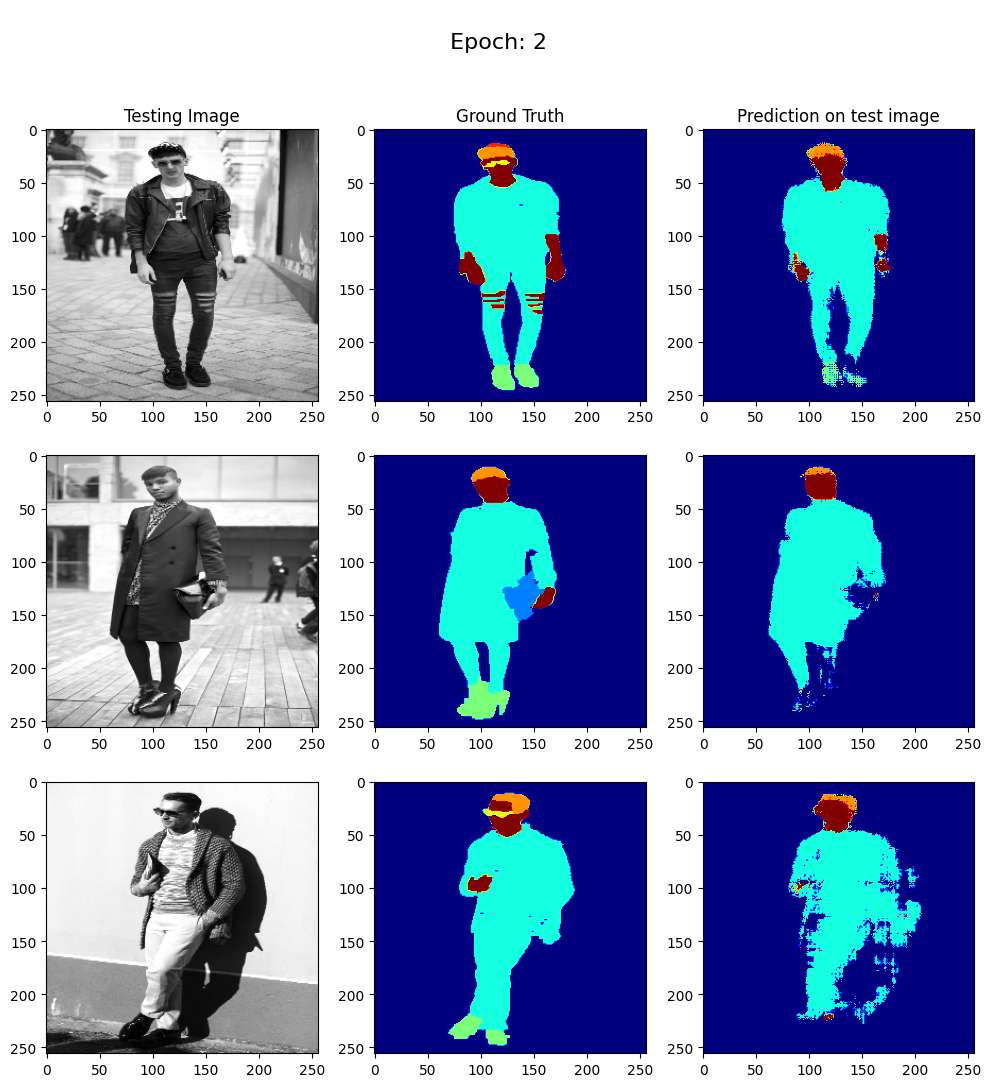


Sample Prediction after epoch 3

56/56 [==============================] - 8s 147ms/step - loss: 0.1839 - accuracy: 0.9435 - val_loss: 0.2376 - val_accuracy: 0.9212
Epoch 4/20
1/1 [==============================] - 0s 38ms/step


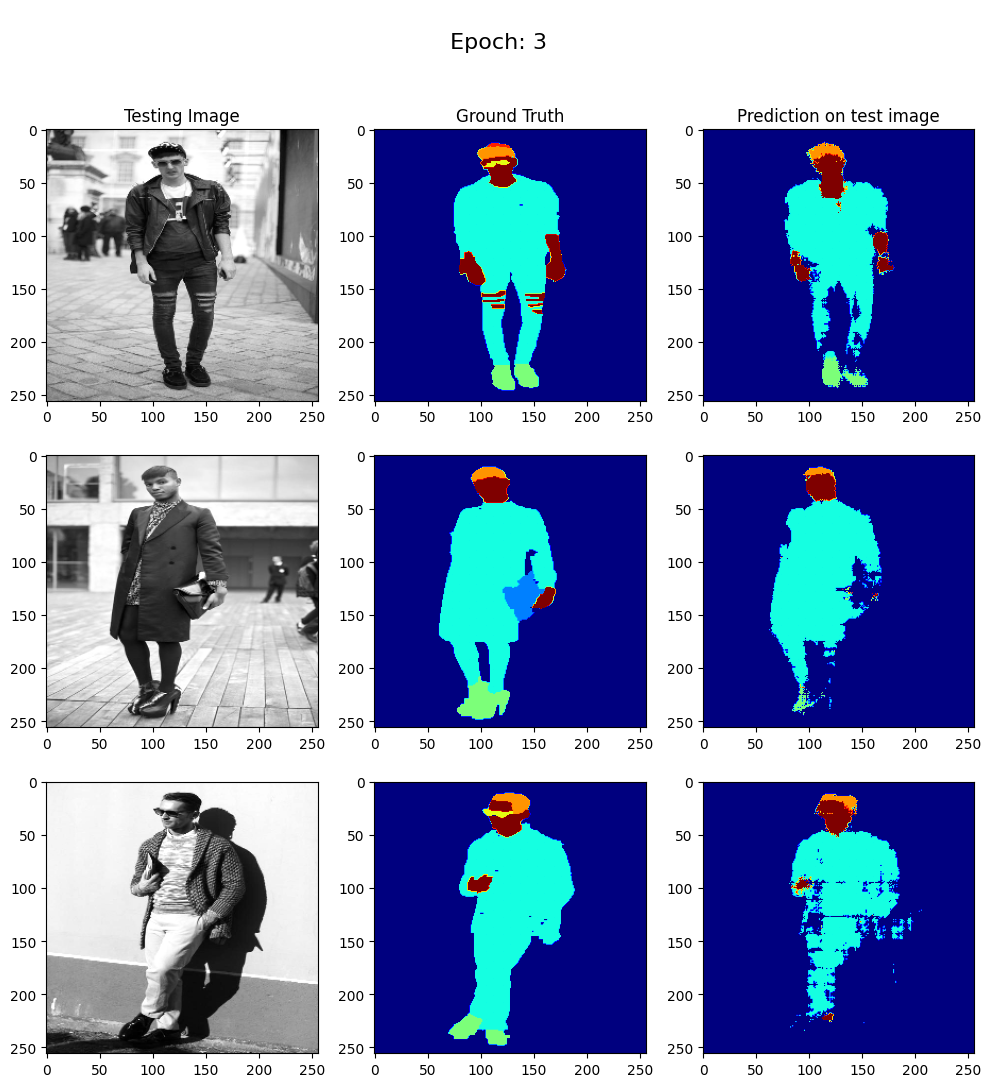


Sample Prediction after epoch 4

56/56 [==============================] - 8s 150ms/step - loss: 0.1496 - accuracy: 0.9519 - val_loss: 0.2522 - val_accuracy: 0.9131
Epoch 5/20
1/1 [==============================] - 0s 23ms/step


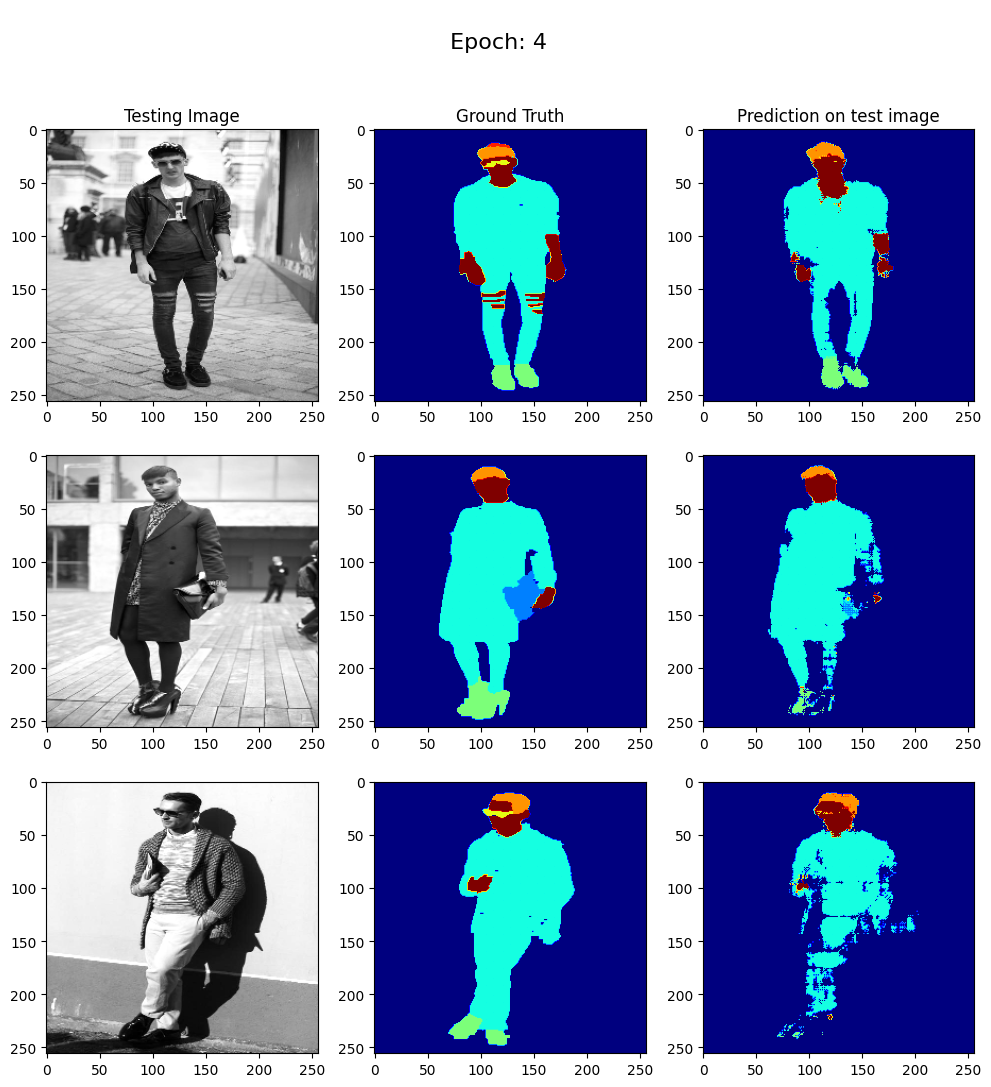


Sample Prediction after epoch 5

56/56 [==============================] - 8s 145ms/step - loss: 0.1347 - accuracy: 0.9553 - val_loss: 0.2421 - val_accuracy: 0.9170
Epoch 6/20
1/1 [==============================] - 0s 23ms/step


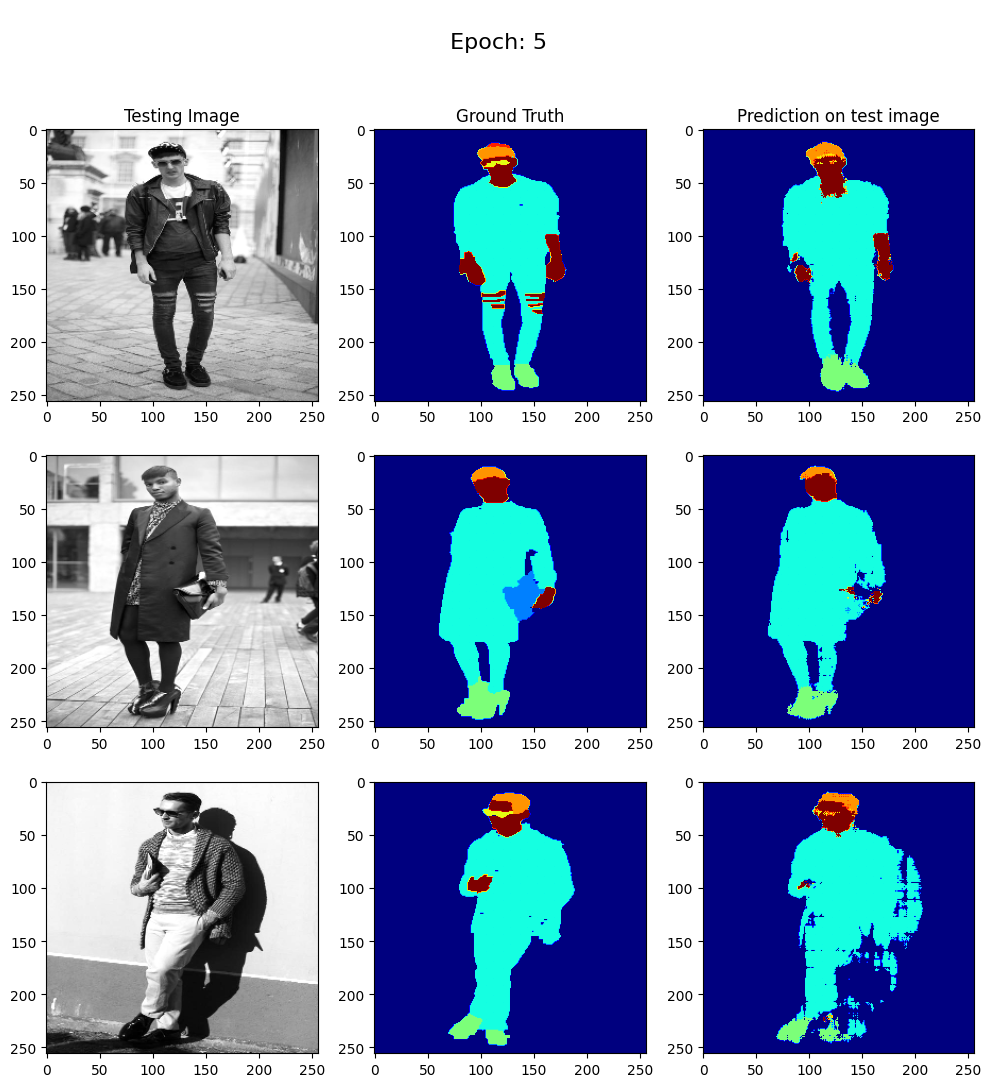


Sample Prediction after epoch 6

56/56 [==============================] - 8s 146ms/step - loss: 0.1231 - accuracy: 0.9585 - val_loss: 0.1555 - val_accuracy: 0.9485
Epoch 7/20
1/1 [==============================] - 0s 23ms/step


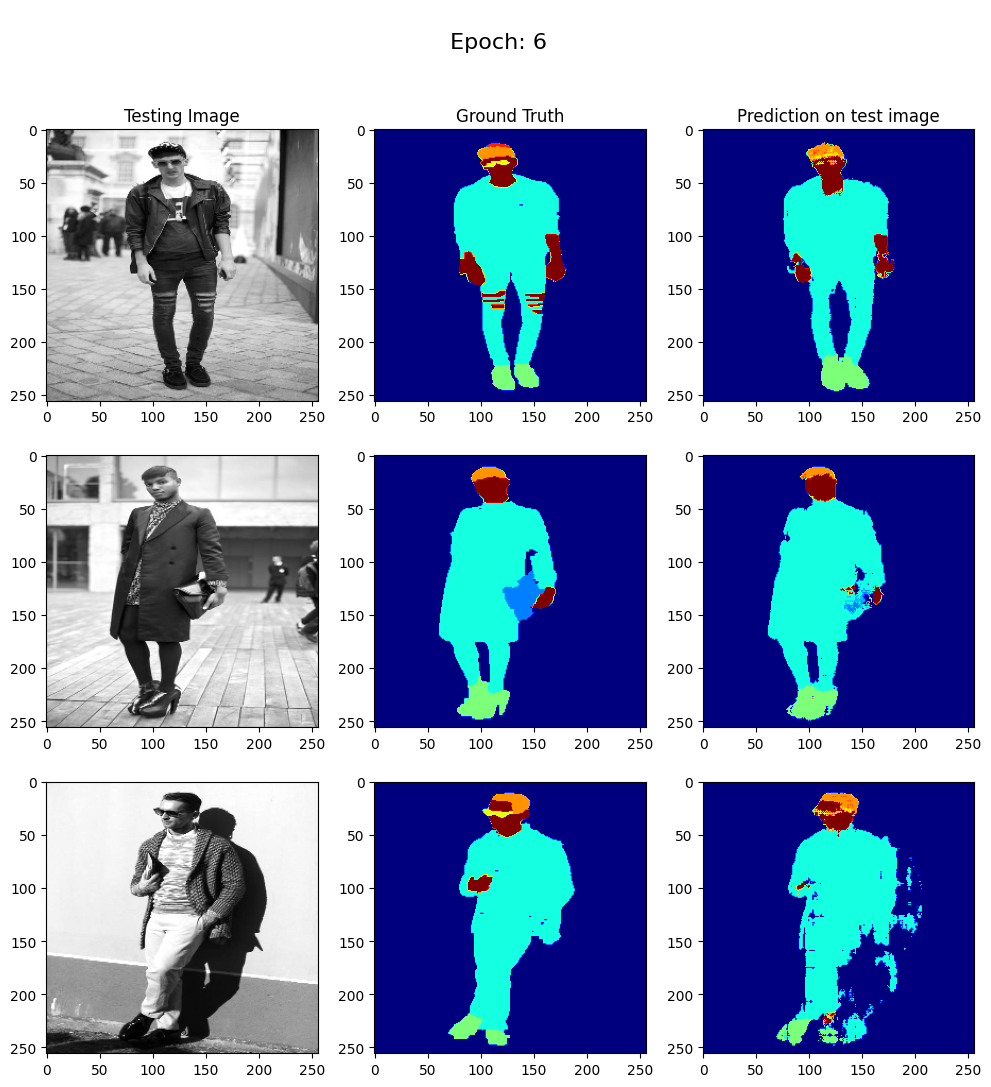


Sample Prediction after epoch 7

56/56 [==============================] - 9s 153ms/step - loss: 0.1128 - accuracy: 0.9616 - val_loss: 0.1541 - val_accuracy: 0.9491
Epoch 8/20
1/1 [==============================] - 0s 24ms/step


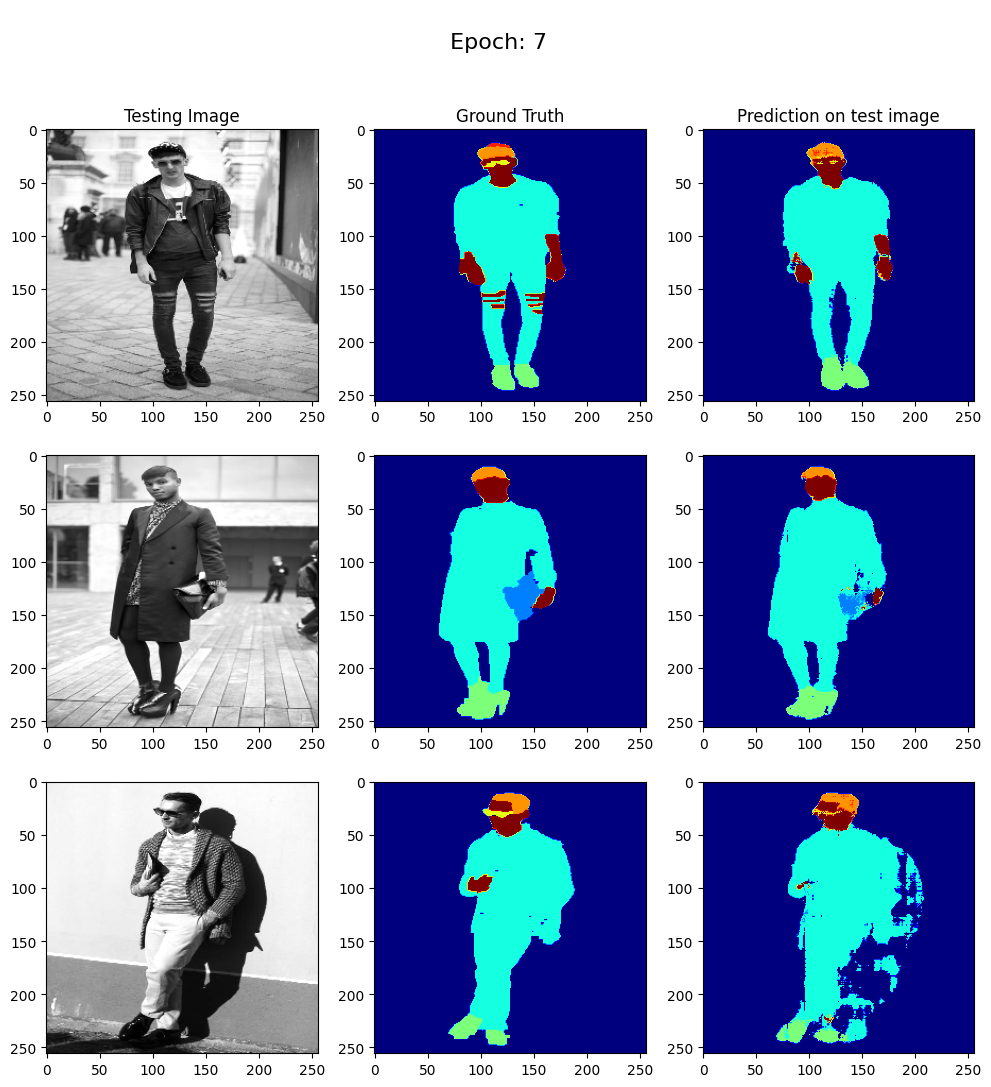


Sample Prediction after epoch 8

56/56 [==============================] - 8s 146ms/step - loss: 0.1083 - accuracy: 0.9629 - val_loss: 0.1422 - val_accuracy: 0.9530
Epoch 9/20
1/1 [==============================] - 0s 22ms/step


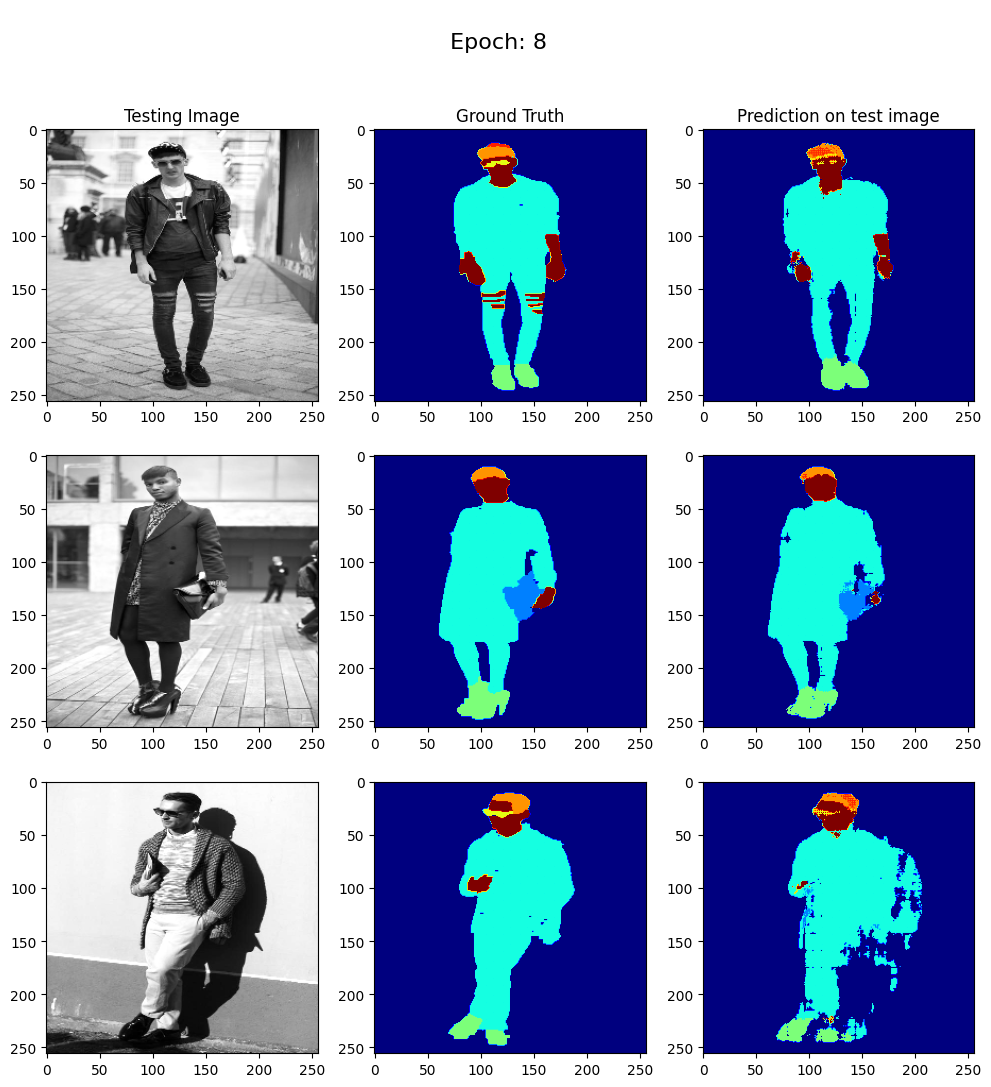


Sample Prediction after epoch 9

56/56 [==============================] - 8s 147ms/step - loss: 0.1036 - accuracy: 0.9642 - val_loss: 0.1508 - val_accuracy: 0.9497
Epoch 10/20
1/1 [==============================] - 0s 23ms/step


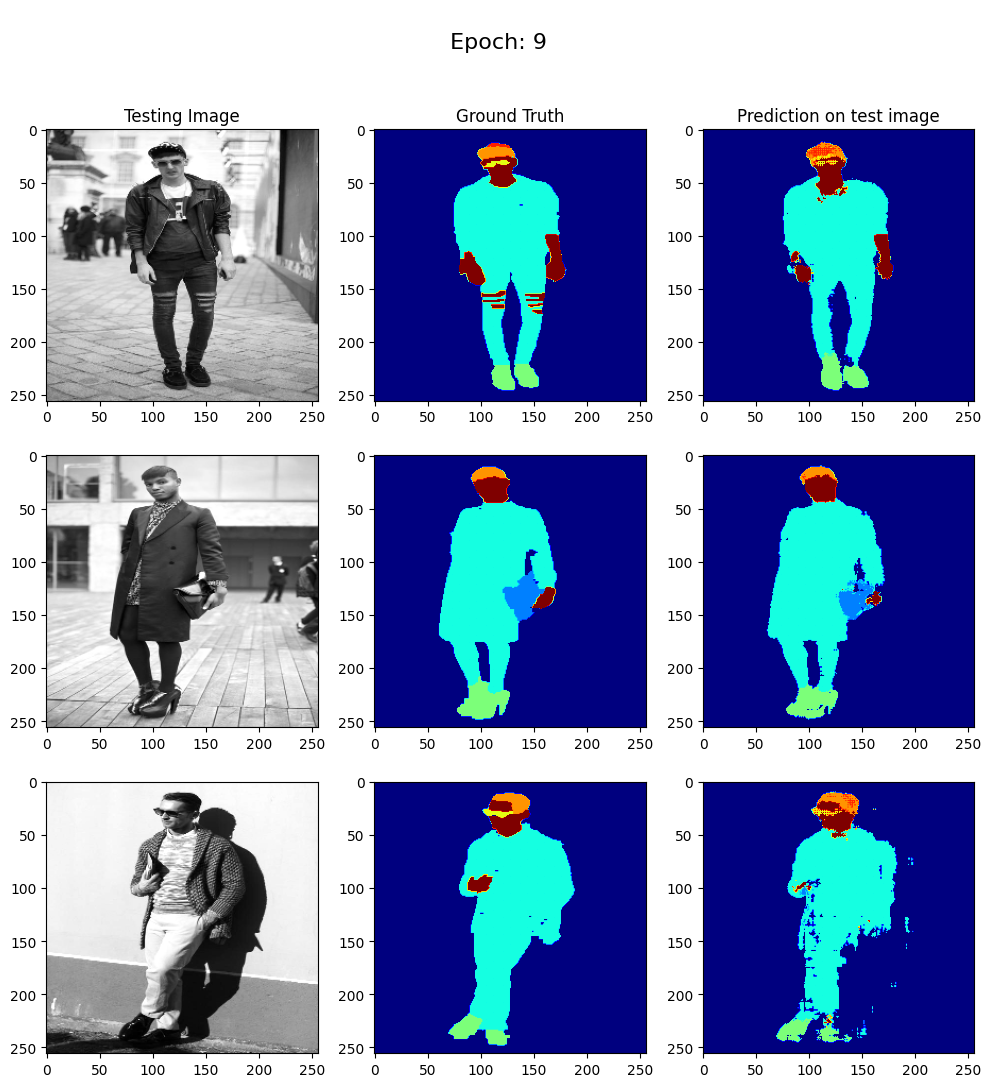


Sample Prediction after epoch 10

56/56 [==============================] - 8s 150ms/step - loss: 0.0961 - accuracy: 0.9667 - val_loss: 0.1537 - val_accuracy: 0.9490
Epoch 11/20
1/1 [==============================] - 0s 22ms/step


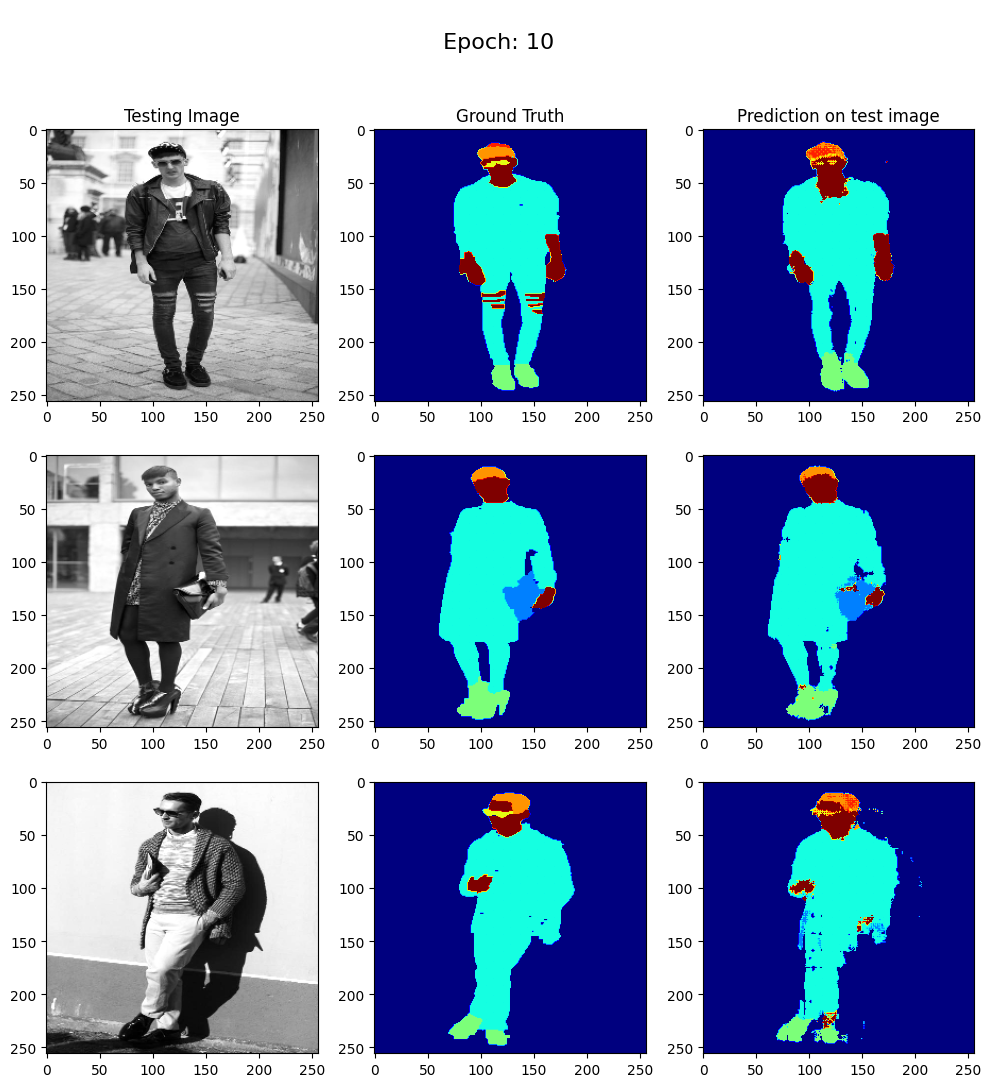


Sample Prediction after epoch 11

56/56 [==============================] - 8s 146ms/step - loss: 0.0911 - accuracy: 0.9683 - val_loss: 0.1594 - val_accuracy: 0.9461
Epoch 12/20
1/1 [==============================] - 0s 23ms/step


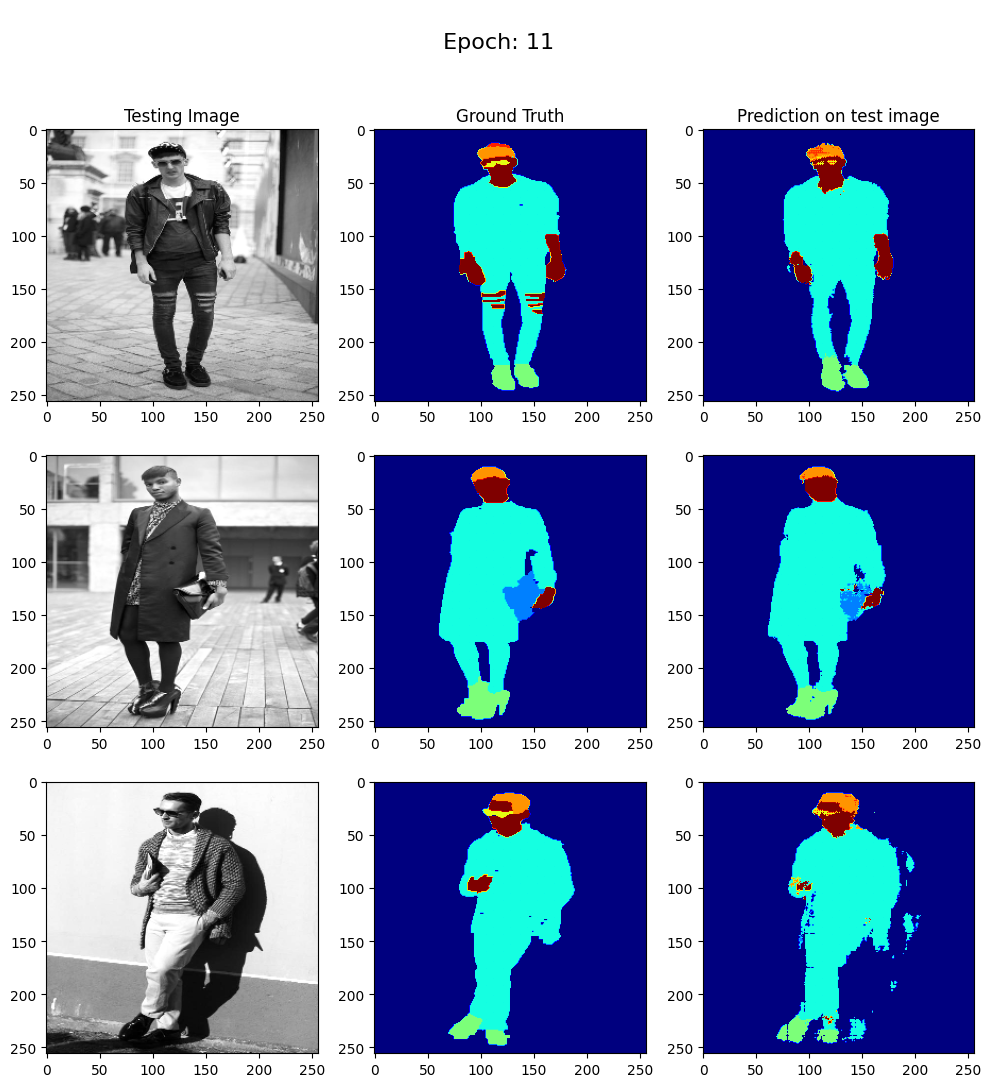


Sample Prediction after epoch 12

56/56 [==============================] - 9s 156ms/step - loss: 0.0858 - accuracy: 0.9700 - val_loss: 0.1444 - val_accuracy: 0.9530
Epoch 13/20
1/1 [==============================] - 0s 25ms/step


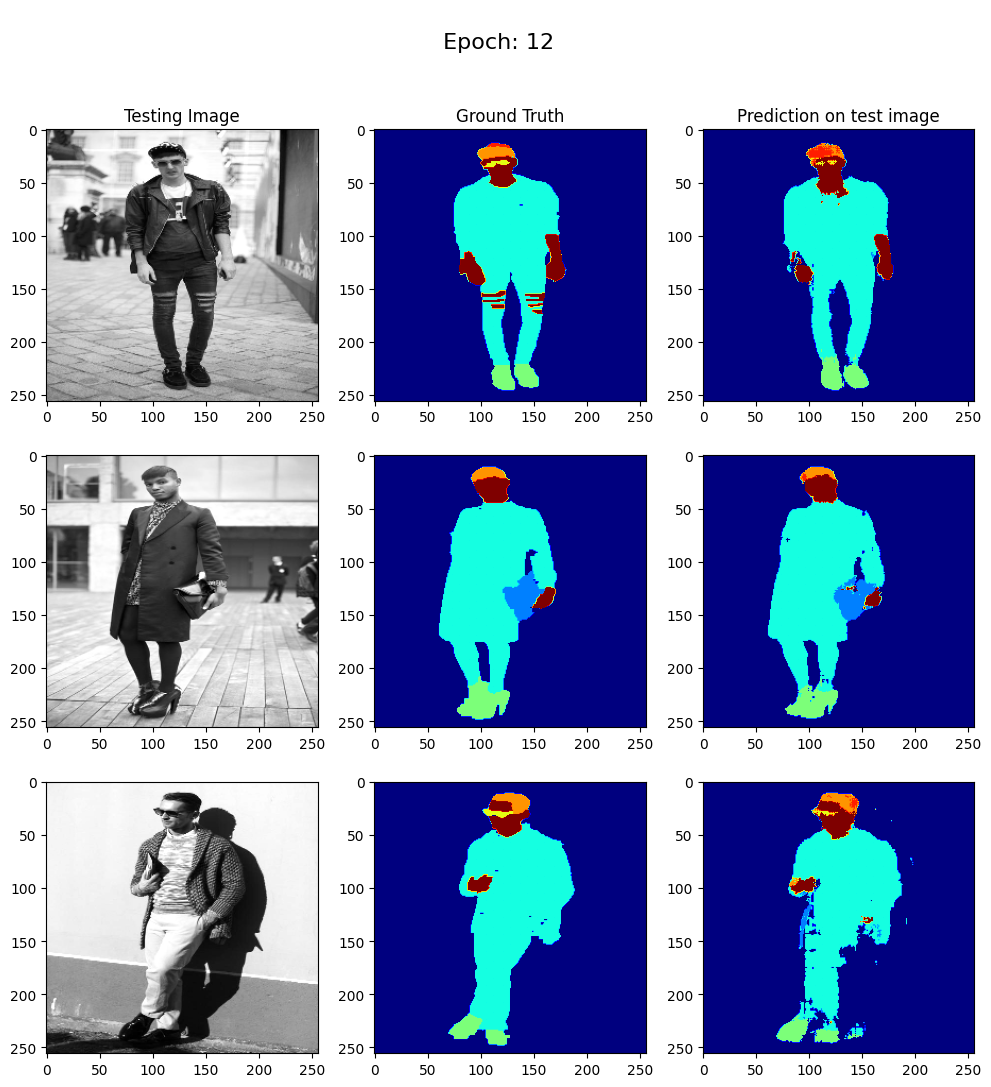


Sample Prediction after epoch 13

56/56 [==============================] - 9s 152ms/step - loss: 0.0820 - accuracy: 0.9715 - val_loss: 0.1614 - val_accuracy: 0.9447
Epoch 14/20
1/1 [==============================] - 0s 42ms/step


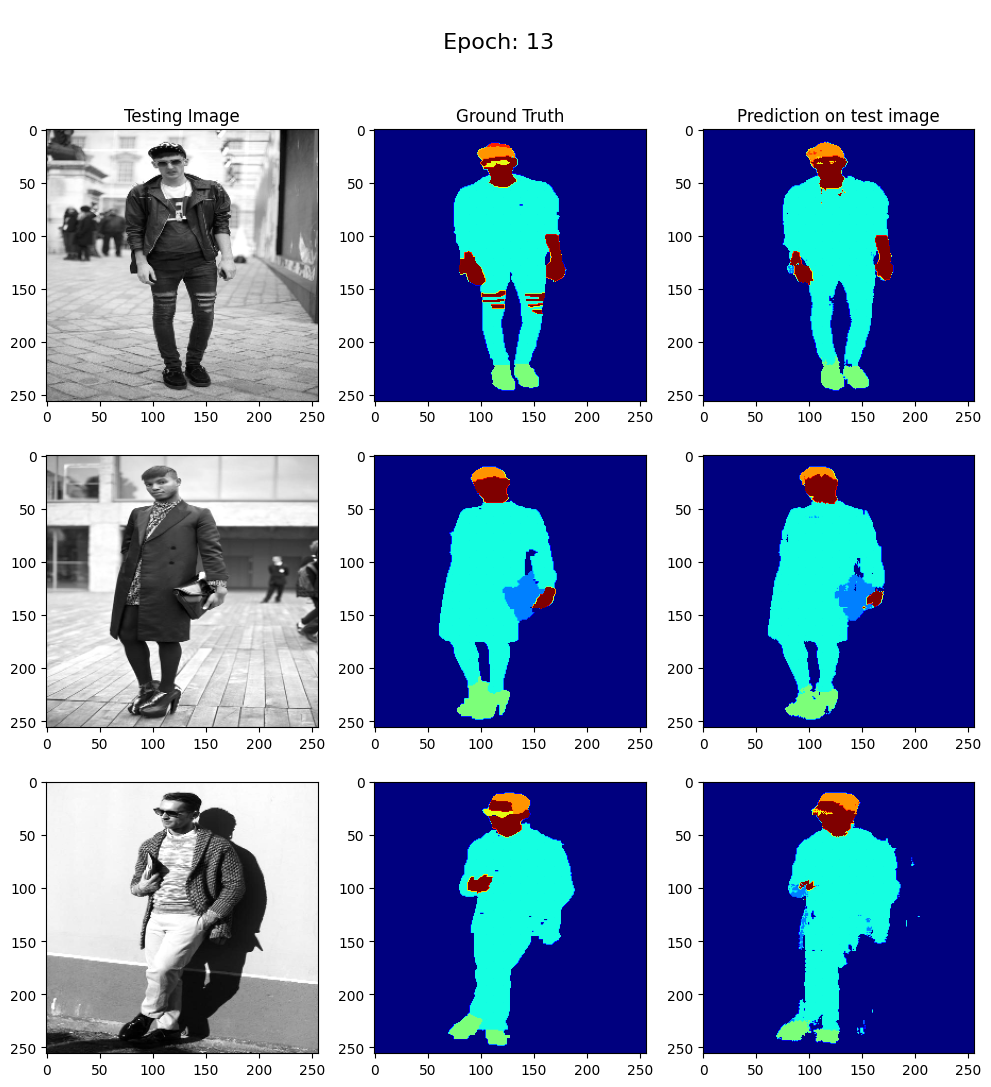


Sample Prediction after epoch 14

56/56 [==============================] - 8s 150ms/step - loss: 0.0753 - accuracy: 0.9737 - val_loss: 0.1490 - val_accuracy: 0.9513
Epoch 15/20
1/1 [==============================] - 0s 31ms/step


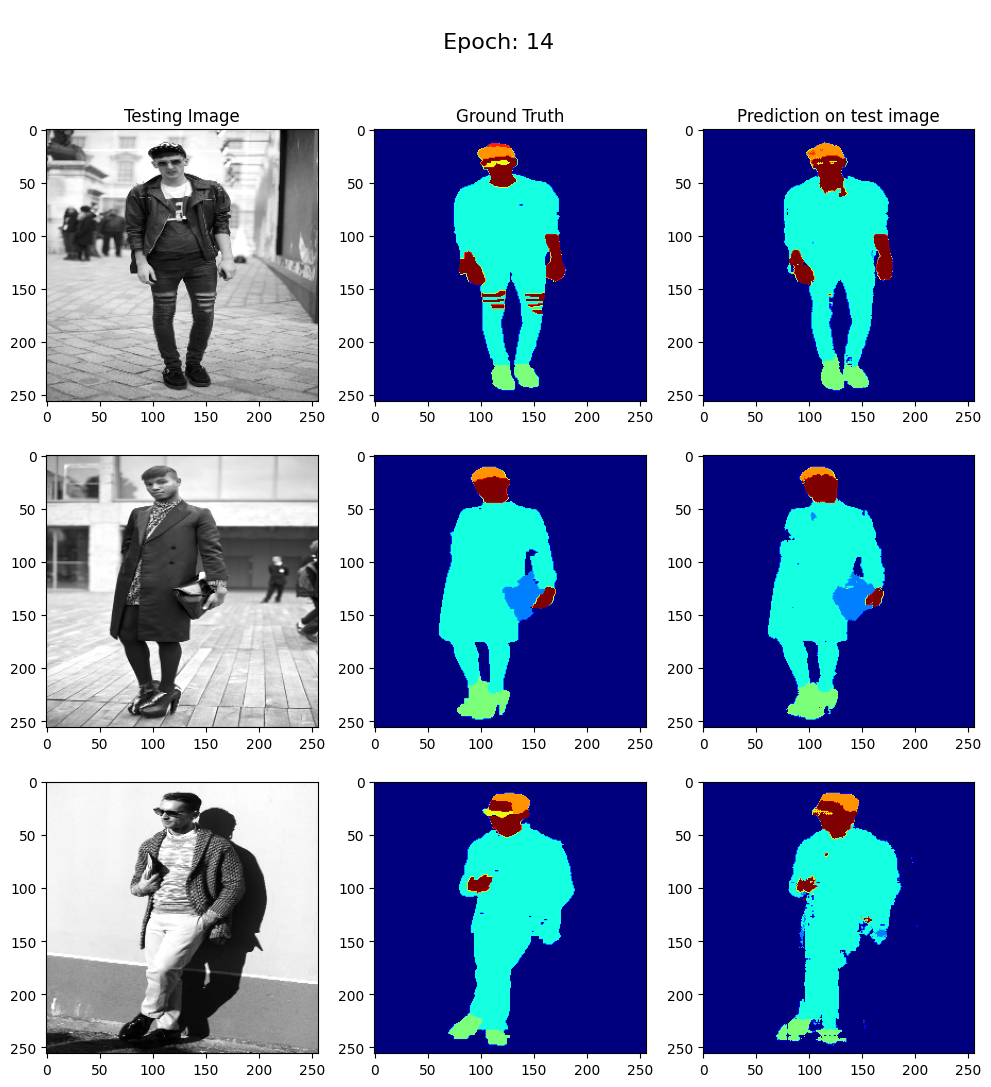


Sample Prediction after epoch 15

56/56 [==============================] - 9s 152ms/step - loss: 0.0708 - accuracy: 0.9753 - val_loss: 0.1516 - val_accuracy: 0.9500
Epoch 16/20
1/1 [==============================] - 0s 39ms/step


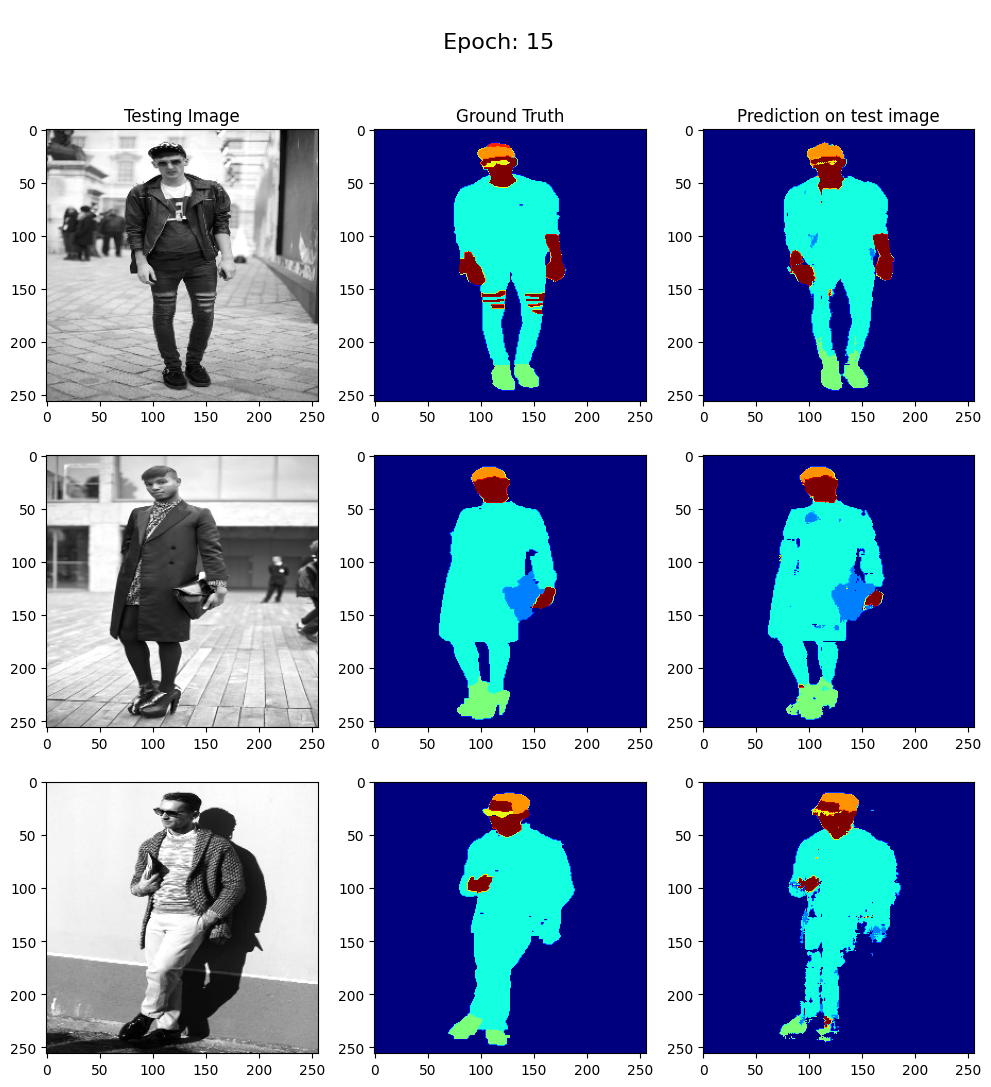


Sample Prediction after epoch 16

56/56 [==============================] - 9s 155ms/step - loss: 0.0641 - accuracy: 0.9775 - val_loss: 0.1939 - val_accuracy: 0.9371
Epoch 17/20
1/1 [==============================] - 0s 25ms/step


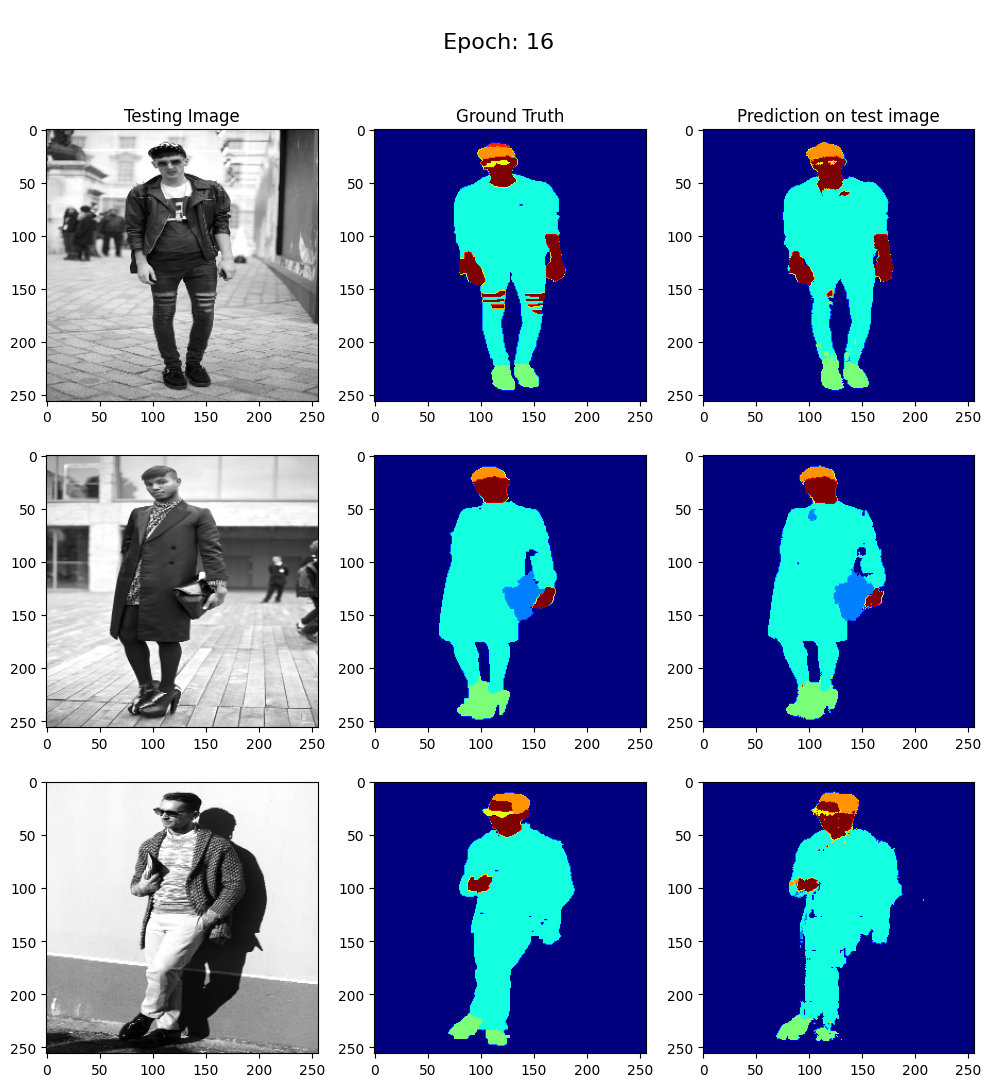


Sample Prediction after epoch 17

56/56 [==============================] - 9s 163ms/step - loss: 0.0619 - accuracy: 0.9782 - val_loss: 0.1639 - val_accuracy: 0.9487
Epoch 18/20
1/1 [==============================] - 0s 38ms/step


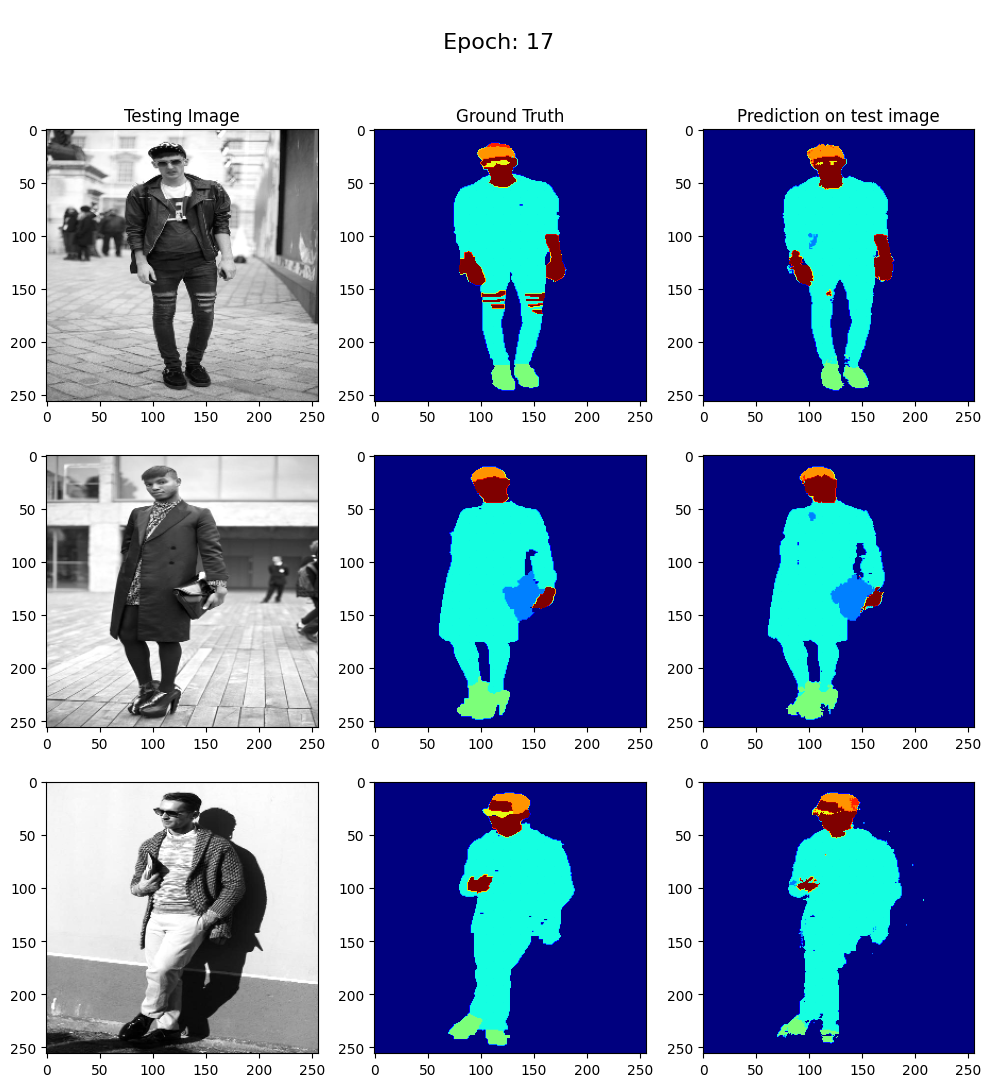


Sample Prediction after epoch 18

56/56 [==============================] - 9s 153ms/step - loss: 0.0573 - accuracy: 0.9798 - val_loss: 0.1698 - val_accuracy: 0.9483
Epoch 19/20
1/1 [==============================] - 0s 35ms/step


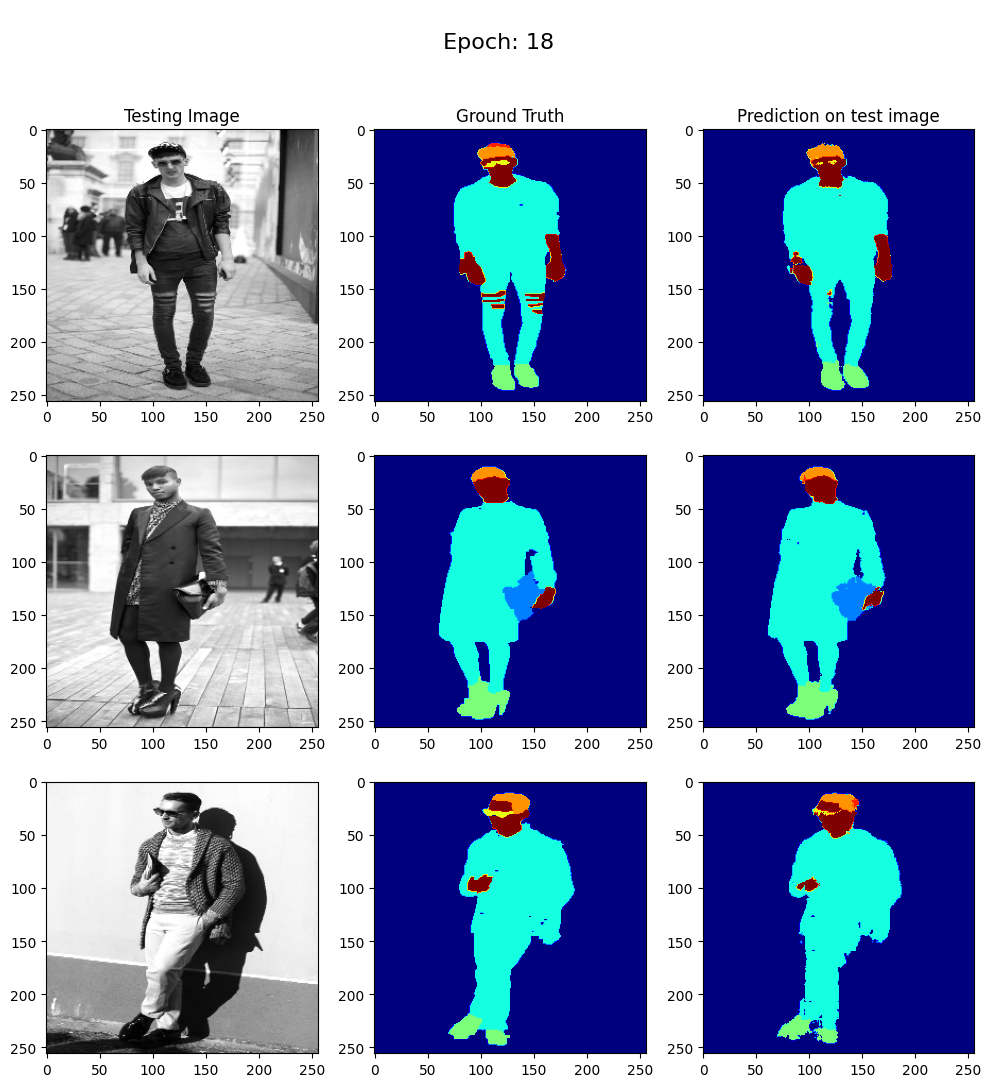


Sample Prediction after epoch 19

56/56 [==============================] - 9s 157ms/step - loss: 0.0535 - accuracy: 0.9810 - val_loss: 0.1657 - val_accuracy: 0.9521
Epoch 20/20
1/1 [==============================] - 0s 51ms/step


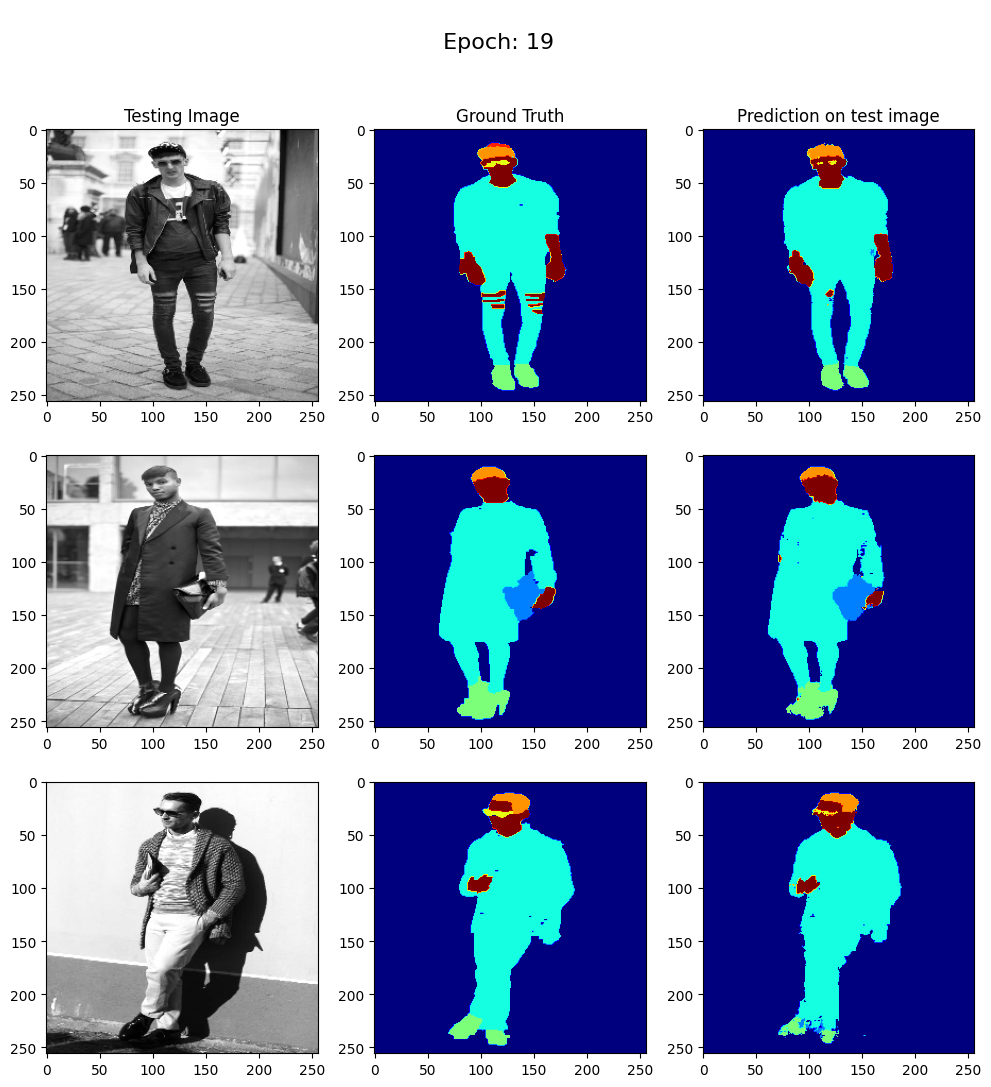


Sample Prediction after epoch 20

56/56 [==============================] - 9s 164ms/step - loss: 0.0491 - accuracy: 0.9824 - val_loss: 0.1646 - val_accuracy: 0.9509


In [17]:
EPOCHS = 20
VAL_SUBSPLITS = 5
BATCH_SIZE = 16
VALIDATION_STEPS = len(X_val)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = len(X_train)//BATCH_SIZE
# sample_image = train_images[0]
# sample_mask = train_masks[0]

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions(epoch)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

model_history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose = 1,
    callbacks = [DisplayCallback()],
    validation_data = (X_val, y_val),
    steps_per_epoch = STEPS_PER_EPOCH,
    validation_steps = VALIDATION_STEPS,
)

In [ ]:
model.save('./models/clothes_50')
#model = load_model('./models/clothes_50')

# Visualize Results

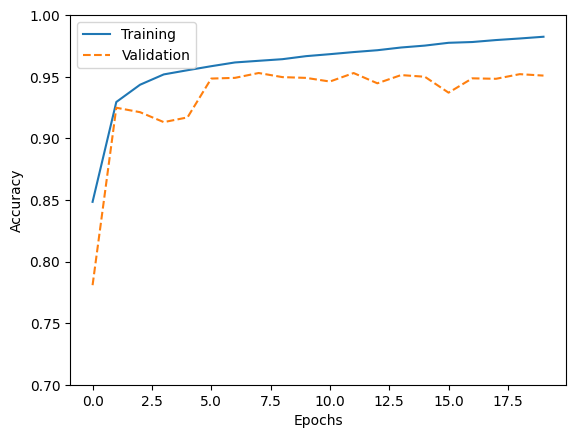

In [19]:
history_1 = model_history.history
acc=history_1['accuracy']
val_acc = history_1['val_accuracy']



plt.plot(acc[:150], '-', label='Training')
plt.plot(val_acc[:150], '--', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.7,1.0])
plt.legend()
plt.show()